In [ ]:
# =========================
# Cell 1: Setup & Imports
# =========================



import copy, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from torchao.quantization import quantize_, int8_weight_only, int4_weight_only

# Device & seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)


Using device: cuda


In [2]:
# =========================
# Cell 2: Data
# =========================

def get_cifar100_loaders(batch_size=128):
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset  = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,  num_workers=2)
    testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader


In [3]:
# =========================
# Cell 3: Model
# =========================

class VGG11(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 4
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 5
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01); nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [ ]:
# =========================
# Cell 4: Helpers (dtype-safe I/O, train/eval, size/time)
# =========================

def model_floating_dtype(model: nn.Module):
    for p in model.parameters():
        if p.is_floating_point():
            return p.dtype
    return torch.float32

def to_model_dtype(x: torch.Tensor, model: nn.Module):
    dt = model_floating_dtype(model)
    return x.to(dtype=dt) if x.is_floating_point() else x

def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in tqdm(trainloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)
        inputs = to_model_dtype(inputs, model)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return running_loss / len(trainloader), 100. * correct / total

@torch.no_grad()
def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in tqdm(testloader, desc="Evaluating", leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)
        # 🔧 Match model dtype
        inputs = to_model_dtype(inputs, model)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return running_loss / len(testloader), 100. * correct / total

def train_model(model, trainloader, testloader, epochs=50, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        te_loss, te_acc = evaluate(model, testloader, criterion, device)
        scheduler.step()

        history['train_loss'].append(tr_loss); history['train_acc'].append(tr_acc)
        history['test_loss'].append(te_loss);   history['test_acc'].append(te_acc)
        best_acc = max(best_acc, te_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.2f}%, "
              f"Test Loss: {te_loss:.4f}, Test Acc: {te_acc:.2f}%")

    return best_acc, history

@torch.no_grad()
def measure_inference_time(model, testloader, device, num_batches=50):
    model.eval()
    times = []
    for i, (inputs, _) in enumerate(testloader):
        if i >= num_batches: break
        inputs = inputs.to(device)
        inputs = to_model_dtype(inputs, model) 
        start = time.time()
        _ = model(inputs)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        end = time.time()
        times.append(end - start)
    return np.mean(times) * 1000.0  

def get_model_size(model):
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 ** 2)


In [ ]:
# =========================
# Cell 5: PTQ & QAT Utilities
# =========================

def _fp32_cpu_copy(m: nn.Module) -> nn.Module:
    c = copy.deepcopy(m).to('cpu')
    for p in c.parameters():
        if p.is_floating_point():
            p.data = p.data.to(torch.float32)
    for b in c.buffers():
        if b.is_floating_point():
            b.data = b.data.to(torch.float32)
    return c

def apply_ptq(model, bit_width: str):
    """Return a quantized copy of `model`."""
    if bit_width in ('fp16', 'bf16'):
        m = copy.deepcopy(model).to(device)
        if bit_width == 'fp16':
            m = m.half()
        else:
            m = m.to(torch.bfloat16)
        return m

    if bit_width == 'int8':
        m_cpu = _fp32_cpu_copy(model)
        m_cpu.eval()
        quantize_(m_cpu, int8_weight_only())
        return m_cpu.to(device)

    if bit_width == 'int4':
        try:
            m_cpu = _fp32_cpu_copy(model)
            m_cpu.eval()
            quantize_(m_cpu, int4_weight_only())
            return m_cpu.to(device)
        except Exception as e:
            print(f"Warning: int4 quantization failed ({e}); falling back to int8 weight-only.")
            m_cpu_fb = _fp32_cpu_copy(model)
            m_cpu_fb.eval()
            quantize_(m_cpu_fb, int8_weight_only())
            return m_cpu_fb.to(device)

    raise ValueError(f"Unknown bit width: {bit_width}")


def run_ptq_experiments(epochs=50):
    print("\n" + "="*80)
    print("TASK 1: POST-TRAINING QUANTIZATION (PTQ)")
    print("="*80 + "\n")

    trainloader, testloader = get_cifar100_loaders()

    print("Training baseline FP32 model...")
    baseline_model = VGG11().to(device)
    baseline_acc, _ = train_model(baseline_model, trainloader, testloader, epochs=epochs)
    torch.save(baseline_model.state_dict(), 'vgg11_baseline.pth')
    print(f"\nBaseline FP32 Accuracy: {baseline_acc:.2f}%")

    bit_widths = ['fp16', 'bf16', 'int8', 'int4']
    ptq_results = {}

    for bw in bit_widths:
        print(f"\n{'='*60}\nApplying PTQ with {bw}\n{'='*60}")
        qmodel = apply_ptq(baseline_model, bw)
        qmodel = qmodel.to(device)

        criterion = nn.CrossEntropyLoss()
        test_loss, test_acc = evaluate(qmodel, testloader, criterion, device)
        size_mb = get_model_size(qmodel)
        t_ms   = measure_inference_time(qmodel, testloader, device)

        ptq_results[bw] = {
            'accuracy': test_acc,
            'accuracy_drop': baseline_acc - test_acc,
            'model_size_mb': size_mb,
            'inference_time_ms': t_ms
        }

        print(f"Accuracy: {test_acc:.2f}%")
        print(f"Accuracy Drop: {baseline_acc - test_acc:.2f}%")
        print(f"Model Size: {size_mb:.2f} MB")
        print(f"Inference Time: {t_ms:.2f} ms")

    return baseline_acc, ptq_results, baseline_model

from torch.ao.quantization import QuantStub, DeQuantStub, fuse_modules

class QuantWrapper(nn.Module):
    """Wraps a float model with Quant/DeQuant stubs so converted model accepts float input."""
    def __init__(self, float_module: nn.Module):
        super().__init__()
        self.quant = QuantStub()
        self.model = float_module
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

def _fuse_conv_bn_relu_in_sequential(seq: nn.Sequential):
    """Fuse Conv2d+BN+ReLU patterns inside a nn.Sequential in-place."""
    idx = 0
    to_fuse = []
    mods = list(seq._modules.items())  
    while idx + 2 < len(mods):
        n0, m0 = mods[idx]
        n1, m1 = mods[idx+1]
        n2, m2 = mods[idx+2]
        if isinstance(m0, nn.Conv2d) and isinstance(m1, nn.BatchNorm2d) and isinstance(m2, nn.ReLU):
            to_fuse.append([n0, n1, n2])
            idx += 3
        else:
            idx += 1
    if to_fuse:
        fuse_modules(seq, to_fuse, inplace=True)

def fuse_vgg11_for_qat(m: VGG11):
    """Fuse Conv-BN-ReLU in VGG11.features (in-place)."""
    m.eval()  
    _fuse_conv_bn_relu_in_sequential(m.features)
   
    return m

def run_qat_experiments(baseline_model, epochs=10, lr=1e-3):
    print("\n" + "="*80)
    print("TASK 1: QUANTIZATION-AWARE TRAINING (QAT)")
    print("="*80 + "\n")

    from torch.ao.quantization.observer import (
        MovingAverageMinMaxObserver,
        PerChannelMinMaxObserver,
    )

    trainloader, testloader = get_cifar100_loaders()
    qat_results = {}
    bit_widths = ['fp16', 'bf16', 'int8']  # (int4 QAT omitted)

    for bw in bit_widths:
        print(f"\n{'='*60}\nQAT Training with {bw}\n{'='*60}")

        qat_model = copy.deepcopy(baseline_model).to(device)

        if bw == 'fp16':
            qat_model = qat_model.half()
            print(f"Fine-tuning for {epochs} epochs...")
            best_acc, history = train_model(qat_model, trainloader, testloader, epochs=epochs, lr=lr)
            size_mb = get_model_size(qat_model)
            t_ms = measure_inference_time(qat_model, testloader, device)
            qat_results[bw] = {
                'accuracy': best_acc, 'model_size_mb': size_mb,
                'inference_time_ms': t_ms, 'history': history
            }
            print(f"Final Accuracy: {best_acc:.2f}%")
            print(f"Model Size: {size_mb:.2f} MB")
            print(f"Inference Time: {t_ms:.2f} ms")
            continue

        if bw == 'bf16':
            qat_model = qat_model.to(torch.bfloat16)
            print(f"Fine-tuning for {epochs} epochs...")
            best_acc, history = train_model(qat_model, trainloader, testloader, epochs=epochs, lr=lr)
            size_mb = get_model_size(qat_model)
            t_ms = measure_inference_time(qat_model, testloader, device)
            qat_results[bw] = {
                'accuracy': best_acc, 'model_size_mb': size_mb,
                'inference_time_ms': t_ms, 'history': history
            }
            print(f"Final Accuracy: {best_acc:.2f}%")
            print(f"Model Size: {size_mb:.2f} MB")
            print(f"Inference Time: {t_ms:.2f} ms")
            continue

        if bw == 'int8':
            
            float_cpu = copy.deepcopy(baseline_model).to('cpu')
            fuse_vgg11_for_qat(float_cpu)                 
            qat_model = QuantWrapper(float_cpu).to(device) 

            from torch.ao.quantization.observer import MovingAverageMinMaxObserver
            default_qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
            per_tensor_linear_qconfig = torch.quantization.QConfig(
                activation=MovingAverageMinMaxObserver.with_args(qscheme=torch.per_tensor_affine, dtype=torch.quint8),
                weight=MovingAverageMinMaxObserver.with_args(qscheme=torch.per_tensor_symmetric, dtype=torch.qint8),
            )

            qat_model.train()
            qat_model.qconfig = default_qconfig
            for m in qat_model.modules():
                if isinstance(m, nn.Linear):
                    m.qconfig = per_tensor_linear_qconfig  

            qat_model = torch.quantization.prepare_qat(qat_model)

            print(f"Fine-tuning for {epochs} epochs...")
            best_acc, history = train_model(qat_model, trainloader, testloader, epochs=epochs, lr=lr)

            qat_model.eval()
            quantized_cpu_model = torch.quantization.convert(qat_model.cpu())

            cpu = torch.device('cpu')
            criterion = nn.CrossEntropyLoss()
            test_loss, test_acc = evaluate(quantized_cpu_model, testloader, criterion, cpu)
            size_mb = get_model_size(quantized_cpu_model)
            t_ms = measure_inference_time(quantized_cpu_model, testloader, cpu)

            qat_results[bw] = {
                'accuracy': test_acc,
                'model_size_mb': size_mb,
                'inference_time_ms': t_ms,
                'history': history
            }
            print(f"Final Accuracy: {test_acc:.2f}%")
            print(f"Model Size: {size_mb:.2f} MB")
            print(f"Inference Time: {t_ms:.2f} ms")
            continue


    return qat_results





In [ ]:
# =========================
# Cell 6: Analysis Blocks
# =========================

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pandas as pd


def plot_scaling_laws(baseline_acc, ptq_results, qat_results):
    print("\n" + "="*80)
    print("TASK 2: SCALING LAW ANALYSIS")
    print("="*80 + "\n")

    bit_mapping = {'fp16': 16, 'bf16': 16, 'int8': 8, 'int4': 4}

    ptq_keys = list(ptq_results.keys())
    ptq_bits = [bit_mapping[k] for k in ptq_keys]
    ptq_accs = [ptq_results[k]['accuracy'] for k in ptq_keys]

    qat_keys = list(qat_results.keys()) if qat_results else []
    qat_bits = [bit_mapping[k] for k in qat_keys]
    qat_accs = [qat_results[k]['accuracy'] for k in qat_keys] if qat_results else []

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    ax = axes[0, 0]
    ax.axhline(y=baseline_acc, linestyle='--', label='Baseline FP32', linewidth=2)
    ax.plot(ptq_bits, ptq_accs, 'o-', label='PTQ', linewidth=2, markersize=8)
    if qat_bits:
        ax.plot(qat_bits, qat_accs, 's-', label='QAT', linewidth=2, markersize=8)
    ax.set_xlabel('Bit-width'); ax.set_ylabel('Accuracy (%)'); ax.set_title('Accuracy vs Bit-width'); ax.legend(); ax.grid(True, alpha=0.3); ax.set_xticks([4, 8, 16])

    ax = axes[0, 1]
    ptq_drops = [baseline_acc - acc for acc in ptq_accs]
    qat_drops = [baseline_acc - acc for acc in qat_accs] if qat_accs else []
    ax.plot(ptq_bits, ptq_drops, 'o-', label='PTQ', linewidth=2, markersize=8)
    if qat_bits:
        ax.plot(qat_bits, qat_drops, 's-', label='QAT', linewidth=2, markersize=8)
    ax.set_xlabel('Bit-width'); ax.set_ylabel('Accuracy Drop (%)'); ax.set_title('Accuracy Drop vs Bit-width'); ax.legend(); ax.grid(True, alpha=0.3); ax.set_xticks([4, 8, 16])

    ax = axes[1, 0]
    ptq_sizes = [ptq_results[k]['model_size_mb'] for k in ptq_keys]
    ax.scatter(ptq_sizes, ptq_accs, s=150, alpha=0.6, label='PTQ')
    for i, bw in enumerate(ptq_keys):
        ax.annotate(bw, (ptq_sizes[i], ptq_accs[i]), fontsize=9)
    if qat_results:
        qat_sizes = [qat_results[k]['model_size_mb'] for k in qat_keys]
        ax.scatter(qat_sizes, qat_accs, s=150, alpha=0.6, marker='s', label='QAT')
        for i, bw in enumerate(qat_keys):
            ax.annotate(bw, (qat_sizes[i], qat_accs[i]), fontsize=9)
    ax.set_xlabel('Model Size (MB)'); ax.set_ylabel('Accuracy (%)'); ax.set_title('Accuracy vs Model Size'); ax.legend(); ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    ptq_times = [ptq_results[k]['inference_time_ms'] for k in ptq_keys]
    ax.scatter(ptq_times, ptq_accs, s=150, alpha=0.6, label='PTQ')
    for i, bw in enumerate(ptq_keys):
        ax.annotate(bw, (ptq_times[i], ptq_accs[i]), fontsize=9)
    if qat_results:
        qat_times = [qat_results[k]['inference_time_ms'] for k in qat_keys]
        ax.scatter(qat_times, qat_accs, s=150, alpha=0.6, marker='s', label='QAT')
        for i, bw in enumerate(qat_keys):
            ax.annotate(bw, (qat_times[i], qat_accs[i]), fontsize=9)
    ax.set_xlabel('Inference Time (ms)'); ax.set_ylabel('Accuracy (%)'); ax.set_title('Accuracy vs Inference Time'); ax.legend(); ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('scaling_law_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nScaling Law Observations:")
    print("-" * 60)
    try:
        print(f"1. PTQ degrades most at lowest bit-width (e.g., int4: {ptq_results.get('int4', {}).get('accuracy', float('nan')):.2f}%)")
    except Exception:
        print("1. PTQ degrades most at lowest bit-width (int4 if available).")
    if qat_accs:
        print(f"2. QAT recovers performance, especially at int8 (≈ {qat_results.get('int8', {}).get('accuracy', float('nan')):.2f}%).")
    print("3. Model size reduction: FP32 → int8 ≈ 4× compression.")
    print("4. Diminishing returns observed below 8-bit precision.")


# ---------- Mixed-Precision (simple + sensitivity) ----------

def compute_layer_sensitivity(model, trainloader, device, max_batches=20):
    model.eval()
    activation_stats = {}

    def get_activation_hook(name):
        def hook(module, inputs, output):
            activation_stats.setdefault(name, []).append(output.detach().cpu().flatten())
        return hook

    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            hooks.append(module.register_forward_hook(get_activation_hook(name)))

    with torch.no_grad():
        for i, (inputs, _) in enumerate(trainloader):
            if i >= max_batches: break
            inputs = inputs.to(device)
            inputs = to_model_dtype(inputs, model)  # dtype-safe
            _ = model(inputs)

    for h in hooks: h.remove()

    sensitivities = {}
    for name, acts_list in activation_stats.items():
        if not acts_list: continue
        acts_np = torch.cat(acts_list).numpy()
        sensitivities[name] = {
            'variance': float(np.var(acts_np)),
            'mean':     float(np.mean(np.abs(acts_np))),
            'max':      float(np.max(np.abs(acts_np))),
        }
    return sensitivities

def run_mixed_precision_experiments(baseline_model):
    print("\n" + "="*80)
    print("TASK 3: MIXED-PRECISION QUANTIZATION")
    print("="*80 + "\n")

    trainloader, testloader = get_cifar100_loaders()
    criterion = nn.CrossEntropyLoss()

    # Config 1: Uniform int8 (weight-only)
    print("\nConfiguration 1: Uniform int8 quantization")
    print("-" * 60)
    uniform_model = apply_ptq(baseline_model, 'int8')
    _, uniform_acc = evaluate(uniform_model, testloader, criterion, device)
    uniform_size = get_model_size(uniform_model)
    uniform_time = measure_inference_time(uniform_model, testloader, device)

    print(f"Accuracy: {uniform_acc:.2f}%")
    print(f"Model Size: {uniform_size:.2f} MB")
    print(f"Inference Time: {uniform_time:.2f} ms")

    # Config 2: (Placeholder) simple mixed precision idea
    print("\nConfiguration 2: Simple mixed-precision (first/last fp16, rest int8)")
    print("-" * 60)
    print("Note: Full layer-wise precision control would use custom wrappers;")
    print("here we demonstrate analysis flow, not per-layer deployment.")

    # Config 3: Sensitivity-based ranking
    print("\nConfiguration 3: Adaptive mixed-precision (sensitivity-based)")
    print("-" * 60)
    sensitivities = compute_layer_sensitivity(baseline_model, trainloader, device)

    # Show top-5 by variance
    print("\nLayer Sensitivity Analysis (Top 5 by variance):")
    if sensitivities:
        sorted_layers = sorted(sensitivities.items(), key=lambda x: x[1]['variance'], reverse=True)
        for i, (name, stats) in enumerate(sorted_layers[:5]):
            print(f"{i+1}. {name} | Var: {stats['variance']:.6f} | MeanAbs: {stats['mean']:.6f} | MaxAbs: {stats['max']:.6f}")

        # Bar plot for top-10
        plt.figure(figsize=(12, 6))
        names = [name for name, _ in sorted_layers[:10]]
        variances = [stats['variance'] for _, stats in sorted_layers[:10]]
        short = [n.split('.')[-1] for n in names]
        plt.bar(range(len(short)), variances)
        plt.xlabel('Layer'); plt.ylabel('Activation Variance'); plt.title('Layer Sensitivity to Quantization')
        plt.xticks(range(len(short)), short, rotation=45, ha='right')
        plt.tight_layout(); plt.savefig('layer_sensitivity.png', dpi=300, bbox_inches='tight'); plt.show()
    else:
        print("No sensitivity stats collected.")

    return {
        'uniform': {'accuracy': uniform_acc, 'model_size_mb': uniform_size, 'inference_time_ms': uniform_time},
        'sensitivities': sensitivities
    }


# ---------- Outlier Analysis ----------

from tqdm import tqdm

@torch.no_grad()
def analyze_activation_outliers(model, dataloader, device, num_batches=20):
    model.eval()
    activation_data = {}
    layer_names = []

    def get_activation_hook(name):
        def hook(module, inputs, output):
            activation_data.setdefault(name, []).append(output.detach().cpu())
        return hook

    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            hooks.append(module.register_forward_hook(get_activation_hook(name)))
            layer_names.append(name)

    for i, (inputs, _) in enumerate(tqdm(dataloader, total=num_batches, desc="Collecting activations")):
        if i >= num_batches: break
        inputs = inputs.to(device)
        inputs = to_model_dtype(inputs, model)  # dtype-safe
        _ = model(inputs)

    for h in hooks: h.remove()

    outlier_analysis = {}
    for name in layer_names:
        if name not in activation_data: continue
        acts = torch.cat(activation_data[name], dim=0).numpy().flatten()
        if acts.size == 0: continue
        mean = np.mean(acts); std = np.std(acts)
        q99 = np.percentile(acts, 99); q999 = np.percentile(acts, 99.9)
        max_val = np.max(np.abs(acts))
        outliers = acts[np.abs(acts - mean) > 3 * std]
        outlier_pct = 100.0 * len(outliers) / len(acts)
        outlier_analysis[name] = {
            'mean': float(mean), 'std': float(std), 'q99': float(q99),
            'q999': float(q999), 'max': float(max_val), 'outlier_pct': float(outlier_pct),
            'activations': acts  # keep for plotting
        }
    return outlier_analysis

def plot_activation_distributions(outlier_analysis, num_layers=6):
    print("\n" + "="*80)
    print("TASK 4: OUTLIER ANALYSIS - ACTIVATION DISTRIBUTIONS")
    print("="*80 + "\n")

    if not outlier_analysis:
        print("No outlier analysis data to plot.")
        return

    layer_names = list(outlier_analysis.keys())[:num_layers]
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, name in enumerate(layer_names):
        if idx >= len(axes): break
        ax = axes[idx]
        acts = outlier_analysis[name]['activations']
        sample_size = min(10000, len(acts))
        acts_sample = np.random.choice(acts, sample_size, replace=False)
        ax.hist(acts_sample, bins=100, alpha=0.7, edgecolor='black')
        ax.axvline(outlier_analysis[name]['q99'], linestyle='--', linewidth=2, label='99th pct')
        ax.axvline(outlier_analysis[name]['q999'], linestyle='--', linewidth=2, label='99.9th pct')
        short_name = name.split('.')[-2] if '.' in name else name
        ax.set_title(f'{short_name}\nOutliers: {outlier_analysis[name]["outlier_pct"]:.2f}%')
        ax.set_xlabel('Activation'); ax.set_ylabel('Freq'); ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

    plt.tight_layout(); plt.savefig('activation_distributions.png', dpi=300, bbox_inches='tight'); plt.show()

    # Boxplot (clipped)
    fig, ax = plt.subplots(figsize=(14, 6))
    labels, data = [], []
    for name in layer_names:
        acts = outlier_analysis[name]['activations']
        lo, hi = np.percentile(acts, 0.1), np.percentile(acts, 99.9)
        clipped = np.clip(acts, lo, hi)
        data.append(clipped)
        labels.append(name.split('.')[-2] if '.' in name else name)
    bp = ax.boxplot(data, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_alpha(0.7)
    ax.set_xlabel('Layer'); ax.set_ylabel('Activation (clipped 0.1–99.9 pct)')
    ax.set_title('Activation Distribution by Layer'); ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout()
    plt.savefig('activation_boxplots.png', dpi=300, bbox_inches='tight'); plt.show()


# ---------- Clipped Quantization (calibration hooks) ----------

class ClippedQuantization:
    def __init__(self, percentile=99.9):
        self.percentile = percentile
        self.clip_values = {}
        self._hooks = []

    @torch.no_grad()
    def calibrate(self, model, dataloader, device, num_batches=20):
        model.eval()
        activation_data = {}

        def get_activation_hook(name):
            def hook(module, inputs, output):
                activation_data.setdefault(name, []).append(output.detach().cpu())
            return hook

        hooks = []
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                hooks.append(module.register_forward_hook(get_activation_hook(name)))

        for i, (inputs, _) in enumerate(dataloader):
            if i >= num_batches: break
            inputs = inputs.to(device)
            inputs = to_model_dtype(inputs, model)  # dtype-safe
            _ = model(inputs)

        for h in hooks: h.remove()

        for name, acts_list in activation_data.items():
            acts = torch.cat(acts_list, dim=0).numpy().flatten()
            if acts.size == 0: continue
            self.clip_values[name] = float(np.percentile(np.abs(acts), self.percentile))

    def attach(self, model):
        def make_hook(name):
            def hook(module, inputs, output):
                clip_val = self.clip_values.get(name, None)
                if clip_val is None: return output
                return torch.clamp(output, min=-clip_val, max=clip_val)
            return hook
        # remove any existing
        self.remove()
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                self._hooks.append(module.register_forward_hook(make_hook(name)))

    def remove(self):
        for h in self._hooks:
            try: h.remove()
            except Exception: pass
        self._hooks = []

def apply_clipped_quantization(model, clip_percentile=99.9):
    return ClippedQuantization(percentile=clip_percentile)


# ---------- Compare Outlier Handling Strategies ----------

def compare_outlier_handling_strategies(baseline_model):
    print("\n" + "="*80)
    print("TASK 4: COMPARING OUTLIER HANDLING STRATEGIES")
    print("="*80 + "\n")

    trainloader, testloader = get_cifar100_loaders()
    criterion = nn.CrossEntropyLoss()

    print("Analyzing activation outliers in baseline model...")
    outlier_analysis = analyze_activation_outliers(baseline_model, testloader, device)
    plot_activation_distributions(outlier_analysis)

    print("\nOutlier Summary Statistics:")
    print("-" * 80)
    print(f"{'Layer':<30} {'Mean':<12} {'Std':<12} {'Max':<12} {'Outliers %':<12}")
    print("-" * 80)
    for name, stats in list(outlier_analysis.items())[:10]:
        short = name.split('.')[-2] if '.' in name else name
        print(f"{short:<30} {stats['mean']:<12.4f} {stats['std']:<12.4f} {stats['max']:<12.4f} {stats['outlier_pct']:<12.2f}")

    print("\n" + "="*60)
    print("Strategy 1: Standard Weight-Only Quantization (No Clipping)")
    print("="*60)
    std_int8 = apply_ptq(baseline_model, 'int8')
    _, acc_int8 = evaluate(std_int8, testloader, criterion, device)
    size_int8 = get_model_size(std_int8)
    print(f"INT8 - Accuracy: {acc_int8:.2f}%, Size: {size_int8:.2f} MB")

    std_int4 = None; acc_int4 = None; size_int4 = None
    try:
        std_int4 = apply_ptq(baseline_model, 'int4')
        _, acc_int4 = evaluate(std_int4, testloader, criterion, device)
        size_int4 = get_model_size(std_int4)
        print(f"INT4 - Accuracy: {acc_int4:.2f}%, Size: {size_int4:.2f} MB")
    except Exception as e:
        print(f"INT4 quantization not fully supported here: {e}")

    print("\n" + "="*60)
    print("Strategy 2: Clipped Quantization (99.9 percentile) — calibration hooks")
    print("="*60)
    clipper = apply_clipped_quantization(baseline_model, clip_percentile=99.9)
    clipper.calibrate(baseline_model, trainloader, device)
    # Show a few thresholds
    print("\nClipping Thresholds (First 5 layers):")
    for i, (name, clip_val) in enumerate(list(clipper.clip_values.items())[:5]):
        short = name.split('.')[-2] if '.' in name else name
        original_max = outlier_analysis.get(name, {}).get('max', None)
        reduction = (100 * (1 - clip_val / original_max)) if original_max not in (None, 0) else float('nan')
        print(f"{short}: {clip_val:.4f} (reduces max by {reduction:.1f}%)")

    # NOTE: We only attach hooks; actual quantized kernels aren’t changed here.
    # In practice you'd quantize weights (e.g., int8 weight-only) AND clamp activations during forward.
    clipper.attach(baseline_model)
    # (Optionally evaluate with clamping in place)
    _, acc_clamped = evaluate(baseline_model, testloader, criterion, device)
    clipper.remove()
    print(f"Eval with activation clamping hooks attached: {acc_clamped:.2f}%")

    # Simple comparison plot
    labels = ['INT8 (std)', 'INT4 (std)', 'Clamp hooks']
    vals = [acc_int8, acc_int4 if acc_int4 is not None else np.nan, acc_clamped]
    plt.figure(figsize=(6,4))
    plt.bar(range(len(labels)), vals)
    plt.xticks(range(len(labels)), labels, rotation=15)
    plt.ylabel('Accuracy (%)'); plt.title('Outlier Handling Comparison')
    plt.tight_layout(); plt.savefig('outlier_handling_comparison.png', dpi=300, bbox_inches='tight'); plt.show()

    return {
        'outlier_analysis': outlier_analysis,
        'standard_int8_acc': acc_int8,
        'standard_int4_acc': acc_int4,
        'clip_eval_acc': acc_clamped,
    }


# ---------- Summary & Curves ----------

def create_results_summary(baseline_acc, ptq_results, qat_results, mixed_precision_results, outlier_results):
    print("\n" + "="*80)
    print("COMPREHENSIVE RESULTS SUMMARY")
    print("="*80 + "\n")

    rows = []
    rows.append({'Method': 'Baseline FP32', 'Bit-width': 32, 'Accuracy (%)': baseline_acc,
                 'Accuracy Drop (%)': 0.0, 'Model Size (MB)': 'N/A', 'Compression Ratio': '1x'})

    for bw, res in ptq_results.items():
        bits = {'fp16':16,'bf16':16,'int8':8,'int4':4}[bw]
        rows.append({
            'Method': f'PTQ-{bw}', 'Bit-width': bits, 'Accuracy (%)': res['accuracy'],
            'Accuracy Drop (%)': res['accuracy_drop'], 'Model Size (MB)': f"{res['model_size_mb']:.2f}",
            'Compression Ratio': f"{32/bits:.1f}x"
        })

    if qat_results:
        for bw, res in qat_results.items():
            bits = {'fp16':16,'bf16':16,'int8':8}[bw]
            rows.append({
                'Method': f'QAT-{bw}', 'Bit-width': bits, 'Accuracy (%)': res['accuracy'],
                'Accuracy Drop (%)': baseline_acc - res['accuracy'],
                'Model Size (MB)': f"{res['model_size_mb']:.2f}",
                'Compression Ratio': f"{32/bits:.1f}x"
            })

    df = pd.DataFrame(rows)
    print(df.to_string(index=False))
    df.to_csv('quantization_results_summary.csv', index=False)
    print("\nSaved -> quantization_results_summary.csv\n")

    print("KEY FINDINGS:")
    print("-" * 80)
    if 'int8' in ptq_results:
        print(f"1) PTQ-int8: ~4× compression with {ptq_results['int8']['accuracy_drop']:.2f}% acc drop.")
    print("2) QAT typically reduces accuracy loss vs PTQ.")
    if 'int4' in ptq_results:
        print("3) int4 often requires special handling (outliers/clipping/mixed-precision).")
    print("4) Mixed-precision can balance accuracy and size.")
    print("5) Outlier handling helps stabilize low-bit setups.")

def plot_qat_training_curves(qat_results):
    if not qat_results:
        print("No QAT results to plot.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for bw, res in qat_results.items():
        if 'history' not in res: continue
        hist = res['history']
        epochs = range(1, len(hist['test_acc']) + 1)
        axes[0].plot(epochs, hist['train_acc'], label=f'QAT-{bw} Train', marker='o')
        axes[0].plot(epochs, hist['test_acc'],  label=f'QAT-{bw} Test',  marker='s')
        axes[1].plot(epochs, hist['train_loss'], label=f'QAT-{bw} Train', marker='o')
        axes[1].plot(epochs, hist['test_loss'],  label=f'QAT-{bw} Test',  marker='s')

    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy (%)'); axes[0].set_title('QAT: Accuracy'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss');          axes[1].set_title('QAT: Loss');     axes[1].legend(); axes[1].grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig('qat_training_curves.png', dpi=300, bbox_inches='tight'); plt.show()


In [7]:
# =========================
# Cell 7: Run
# =========================

print("="*80)
print("NEURAL NETWORK QUANTIZATION ANALYSIS")
print("VGG-11 on CIFAR-100")
print("="*80)

baseline_acc, ptq_results, baseline_model = run_ptq_experiments(epochs=50)



NEURAL NETWORK QUANTIZATION ANALYSIS
VGG-11 on CIFAR-100

TASK 1: POST-TRAINING QUANTIZATION (PTQ)



100%|██████████| 169M/169M [00:06<00:00, 25.4MB/s]


Training baseline FP32 model...


Epoch 1/50 - Train Loss: 4.5360, Train Acc: 1.45%, Test Loss: 4.4190, Test Acc: 2.62%


Epoch 2/50 - Train Loss: 4.1737, Train Acc: 4.44%, Test Loss: 3.9126, Test Acc: 6.63%


Epoch 3/50 - Train Loss: 3.7963, Train Acc: 8.96%, Test Loss: 3.5993, Test Acc: 12.36%


Epoch 4/50 - Train Loss: 3.4741, Train Acc: 13.76%, Test Loss: 3.2521, Test Acc: 17.88%


Epoch 5/50 - Train Loss: 3.2231, Train Acc: 18.33%, Test Loss: 3.0765, Test Acc: 21.15%


Epoch 6/50 - Train Loss: 3.0231, Train Acc: 22.08%, Test Loss: 2.7937, Test Acc: 25.98%


Epoch 7/50 - Train Loss: 2.8762, Train Acc: 24.90%, Test Loss: 2.7881, Test Acc: 26.33%


Epoch 8/50 - Train Loss: 2.7243, Train Acc: 28.14%, Test Loss: 2.6724, Test Acc: 29.99%


Epoch 9/50 - Train Loss: 2.5986, Train Acc: 30.83%, Test Loss: 2.5159, Test Acc: 32.81%


Epoch 10/50 - Train Loss: 2.4866, Train Acc: 33.25%, Test Loss: 2.3394, Test Acc: 37.34%


Epoch 11/50 - Train Loss: 2.3741, Train Acc: 36.28%, Test Loss: 2.3134, Test Acc: 38.10%


Epoch 12/50 - Train Loss: 2.2739, Train Acc: 38.38%, Test Loss: 2.1905, Test Acc: 41.62%


Epoch 13/50 - Train Loss: 2.1814, Train Acc: 40.57%, Test Loss: 2.1283, Test Acc: 42.43%


Epoch 14/50 - Train Loss: 2.1050, Train Acc: 42.10%, Test Loss: 2.0111, Test Acc: 45.85%


Epoch 15/50 - Train Loss: 2.0235, Train Acc: 44.32%, Test Loss: 2.0225, Test Acc: 44.79%


Epoch 16/50 - Train Loss: 1.9570, Train Acc: 45.90%, Test Loss: 1.9628, Test Acc: 46.94%


Epoch 17/50 - Train Loss: 1.8907, Train Acc: 47.80%, Test Loss: 1.8926, Test Acc: 48.46%


Epoch 18/50 - Train Loss: 1.8227, Train Acc: 48.98%, Test Loss: 1.8950, Test Acc: 48.41%


Epoch 19/50 - Train Loss: 1.7619, Train Acc: 50.67%, Test Loss: 1.7670, Test Acc: 51.59%


Epoch 20/50 - Train Loss: 1.7091, Train Acc: 51.91%, Test Loss: 1.7789, Test Acc: 51.73%


Epoch 21/50 - Train Loss: 1.6554, Train Acc: 53.41%, Test Loss: 1.7496, Test Acc: 52.20%


Epoch 22/50 - Train Loss: 1.5927, Train Acc: 54.59%, Test Loss: 1.7775, Test Acc: 51.99%


Epoch 23/50 - Train Loss: 1.5478, Train Acc: 55.83%, Test Loss: 1.6724, Test Acc: 54.48%


Epoch 24/50 - Train Loss: 1.4945, Train Acc: 57.10%, Test Loss: 1.6700, Test Acc: 54.42%


Epoch 25/50 - Train Loss: 1.4397, Train Acc: 58.57%, Test Loss: 1.6309, Test Acc: 55.52%


Epoch 26/50 - Train Loss: 1.3948, Train Acc: 59.69%, Test Loss: 1.6334, Test Acc: 56.03%


Epoch 27/50 - Train Loss: 1.3467, Train Acc: 60.96%, Test Loss: 1.6541, Test Acc: 56.21%


Epoch 28/50 - Train Loss: 1.2996, Train Acc: 62.26%, Test Loss: 1.5841, Test Acc: 57.43%


Epoch 29/50 - Train Loss: 1.2511, Train Acc: 63.40%, Test Loss: 1.6281, Test Acc: 57.18%


Epoch 30/50 - Train Loss: 1.2061, Train Acc: 64.54%, Test Loss: 1.5923, Test Acc: 57.20%


Epoch 31/50 - Train Loss: 1.1615, Train Acc: 65.79%, Test Loss: 1.5660, Test Acc: 58.72%


Epoch 32/50 - Train Loss: 1.1127, Train Acc: 66.99%, Test Loss: 1.5793, Test Acc: 58.75%


Epoch 33/50 - Train Loss: 1.0635, Train Acc: 68.44%, Test Loss: 1.5683, Test Acc: 59.06%


Epoch 34/50 - Train Loss: 1.0302, Train Acc: 69.40%, Test Loss: 1.5616, Test Acc: 59.47%


Epoch 35/50 - Train Loss: 0.9736, Train Acc: 70.76%, Test Loss: 1.5505, Test Acc: 60.41%


Epoch 36/50 - Train Loss: 0.9306, Train Acc: 71.93%, Test Loss: 1.5642, Test Acc: 60.24%


Epoch 37/50 - Train Loss: 0.8938, Train Acc: 72.71%, Test Loss: 1.5646, Test Acc: 61.11%


Epoch 38/50 - Train Loss: 0.8572, Train Acc: 73.89%, Test Loss: 1.5616, Test Acc: 60.90%


Epoch 39/50 - Train Loss: 0.8170, Train Acc: 75.07%, Test Loss: 1.5464, Test Acc: 61.35%


Epoch 40/50 - Train Loss: 0.7747, Train Acc: 76.12%, Test Loss: 1.5715, Test Acc: 61.86%


Epoch 41/50 - Train Loss: 0.7416, Train Acc: 77.18%, Test Loss: 1.5635, Test Acc: 62.10%


Epoch 42/50 - Train Loss: 0.7056, Train Acc: 78.09%, Test Loss: 1.5645, Test Acc: 62.22%


Epoch 43/50 - Train Loss: 0.6813, Train Acc: 78.88%, Test Loss: 1.5531, Test Acc: 62.31%


Epoch 44/50 - Train Loss: 0.6488, Train Acc: 79.82%, Test Loss: 1.5658, Test Acc: 62.61%


Epoch 45/50 - Train Loss: 0.6307, Train Acc: 80.35%, Test Loss: 1.5614, Test Acc: 62.72%


Epoch 46/50 - Train Loss: 0.6060, Train Acc: 81.15%, Test Loss: 1.5576, Test Acc: 62.74%


Epoch 47/50 - Train Loss: 0.5936, Train Acc: 81.54%, Test Loss: 1.5801, Test Acc: 62.70%


Epoch 48/50 - Train Loss: 0.5865, Train Acc: 81.77%, Test Loss: 1.5730, Test Acc: 62.82%


Epoch 49/50 - Train Loss: 0.5816, Train Acc: 81.76%, Test Loss: 1.5667, Test Acc: 63.09%


Epoch 50/50 - Train Loss: 0.5753, Train Acc: 81.86%, Test Loss: 1.5673, Test Acc: 63.06%

Baseline FP32 Accuracy: 63.09%

Applying PTQ with fp16


Accuracy: 63.04%
Accuracy Drop: 0.05%
Model Size: 18.71 MB
Inference Time: 7.55 ms

Applying PTQ with bf16


Accuracy: 63.11%
Accuracy Drop: -0.02%
Model Size: 18.71 MB
Inference Time: 271.52 ms

Applying PTQ with int8


Accuracy: 63.01%
Accuracy Drop: 0.08%
Model Size: 37.41 MB
Inference Time: 9.94 ms

Applying PTQ with int4

CUDA: registered at /pytorch/build/aten/src/ATen/RegisterCUDA_0.cpp:16092 [kernel]
Meta: registered at /dev/null:488 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:375 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/s

Accuracy: 63.01%
Accuracy Drop: 0.08%
Model Size: 37.41 MB
Inference Time: 10.35 ms


In [8]:
print("\n[2/6] Running QAT experiments...")
qat_results = run_qat_experiments(baseline_model, epochs=10, lr=1e-3)


[2/6] Running QAT experiments...

TASK 1: QUANTIZATION-AWARE TRAINING (QAT)


QAT Training with fp16
Fine-tuning for 10 epochs...


Epoch 1/10 - Train Loss: 0.6578, Train Acc: 79.02%, Test Loss: 1.6035, Test Acc: 61.69%


Epoch 2/10 - Train Loss: 0.6552, Train Acc: 79.56%, Test Loss: 1.6351, Test Acc: 61.81%


Epoch 3/10 - Train Loss: 0.6365, Train Acc: 79.91%, Test Loss: 1.6146, Test Acc: 61.85%


Epoch 4/10 - Train Loss: 0.6120, Train Acc: 80.83%, Test Loss: 1.6305, Test Acc: 62.10%


Epoch 5/10 - Train Loss: 0.5901, Train Acc: 81.68%, Test Loss: 1.6245, Test Acc: 62.35%


Epoch 6/10 - Train Loss: 0.5571, Train Acc: 82.44%, Test Loss: 1.6231, Test Acc: 61.97%


Epoch 7/10 - Train Loss: 0.5414, Train Acc: 82.82%, Test Loss: 1.5975, Test Acc: 62.83%


Epoch 8/10 - Train Loss: 0.5221, Train Acc: 83.78%, Test Loss: 1.6014, Test Acc: 62.57%


Epoch 9/10 - Train Loss: 0.5125, Train Acc: 83.96%, Test Loss: 1.5941, Test Acc: 62.70%


Epoch 10/10 - Train Loss: 0.5076, Train Acc: 83.98%, Test Loss: 1.5955, Test Acc: 62.40%


Final Accuracy: 62.83%
Model Size: 18.71 MB
Inference Time: 7.80 ms

QAT Training with bf16
Fine-tuning for 10 epochs...


Epoch 1/10 - Train Loss: 0.5891, Train Acc: 81.68%, Test Loss: 1.5833, Test Acc: 62.59%


Epoch 2/10 - Train Loss: 0.5912, Train Acc: 81.36%, Test Loss: 1.5800, Test Acc: 62.72%


Epoch 3/10 - Train Loss: 0.5776, Train Acc: 82.00%, Test Loss: 1.5782, Test Acc: 62.75%


Epoch 4/10 - Train Loss: 0.5720, Train Acc: 82.15%, Test Loss: 1.5759, Test Acc: 62.66%


Epoch 5/10 - Train Loss: 0.5661, Train Acc: 82.27%, Test Loss: 1.5767, Test Acc: 62.73%


Epoch 6/10 - Train Loss: 0.5603, Train Acc: 82.42%, Test Loss: 1.5759, Test Acc: 62.87%


Epoch 7/10 - Train Loss: 0.5576, Train Acc: 82.65%, Test Loss: 1.5718, Test Acc: 62.73%


Epoch 8/10 - Train Loss: 0.5526, Train Acc: 82.87%, Test Loss: 1.5817, Test Acc: 62.97%


Epoch 9/10 - Train Loss: 0.5485, Train Acc: 82.99%, Test Loss: 1.5766, Test Acc: 62.77%


Epoch 10/10 - Train Loss: 0.5497, Train Acc: 82.72%, Test Loss: 1.5735, Test Acc: 62.65%


Final Accuracy: 62.97%
Model Size: 18.71 MB
Inference Time: 271.95 ms

QAT Training with int8


/tmp/ipython-input-316290915.py:207: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qat_model = torch.quantization.prepare_qat(qat_model)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release o

Fine-tuning for 10 epochs...


Epoch 1/10 - Train Loss: 0.7026, Train Acc: 78.12%, Test Loss: 1.6279, Test Acc: 60.85%


Epoch 2/10 - Train Loss: 0.6808, Train Acc: 78.80%, Test Loss: 1.6845, Test Acc: 60.14%


Epoch 3/10 - Train Loss: 0.6593, Train Acc: 79.47%, Test Loss: 1.6622, Test Acc: 61.37%


Epoch 4/10 - Train Loss: 0.6332, Train Acc: 80.33%, Test Loss: 1.6221, Test Acc: 61.80%


Epoch 5/10 - Train Loss: 0.6066, Train Acc: 81.02%, Test Loss: 1.6594, Test Acc: 61.26%


Epoch 6/10 - Train Loss: 0.5706, Train Acc: 81.93%, Test Loss: 1.6738, Test Acc: 62.16%


Epoch 7/10 - Train Loss: 0.5398, Train Acc: 82.90%, Test Loss: 1.6885, Test Acc: 61.88%


Epoch 8/10 - Train Loss: 0.5191, Train Acc: 83.75%, Test Loss: 1.6690, Test Acc: 62.47%


Epoch 9/10 - Train Loss: 0.4989, Train Acc: 84.23%, Test Loss: 1.6566, Test Acc: 62.87%


/tmp/ipython-input-316290915.py:214: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_cpu_model = torch.quantization.convert(qat_model.cpu())


Epoch 10/10 - Train Loss: 0.4839, Train Acc: 84.78%, Test Loss: 1.6528, Test Acc: 62.95%


Final Accuracy: 62.79%
Model Size: 0.00 MB
Inference Time: 376.88 ms



[2a] Plotting QAT training curves...


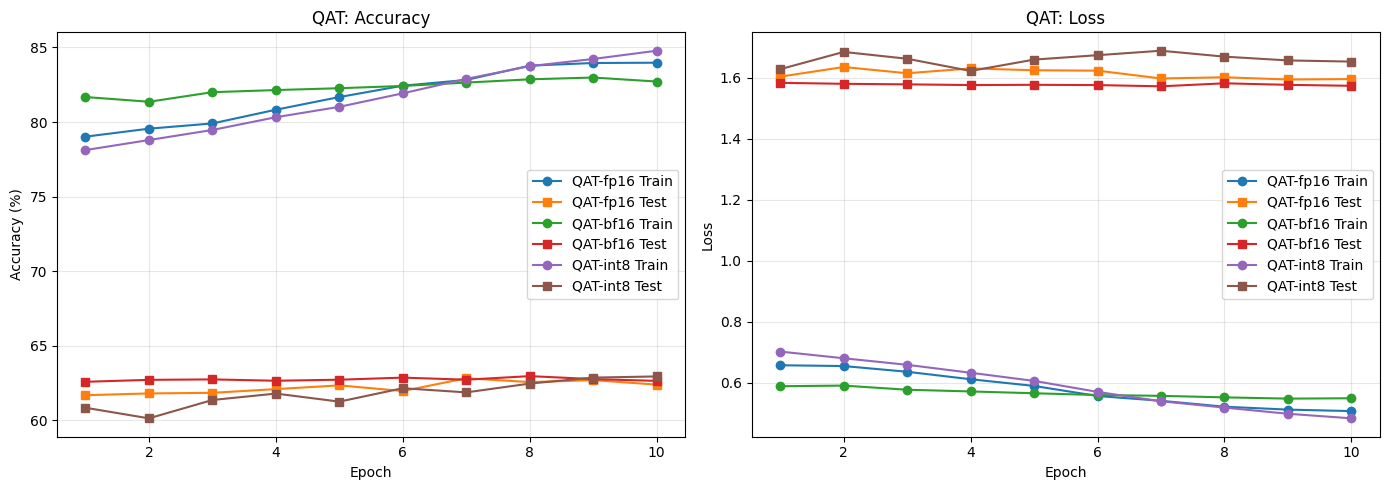

In [9]:
print("\n[2a] Plotting QAT training curves...")
plot_qat_training_curves(qat_results)


[3/6] Plotting scaling-law analysis...

TASK 2: SCALING LAW ANALYSIS



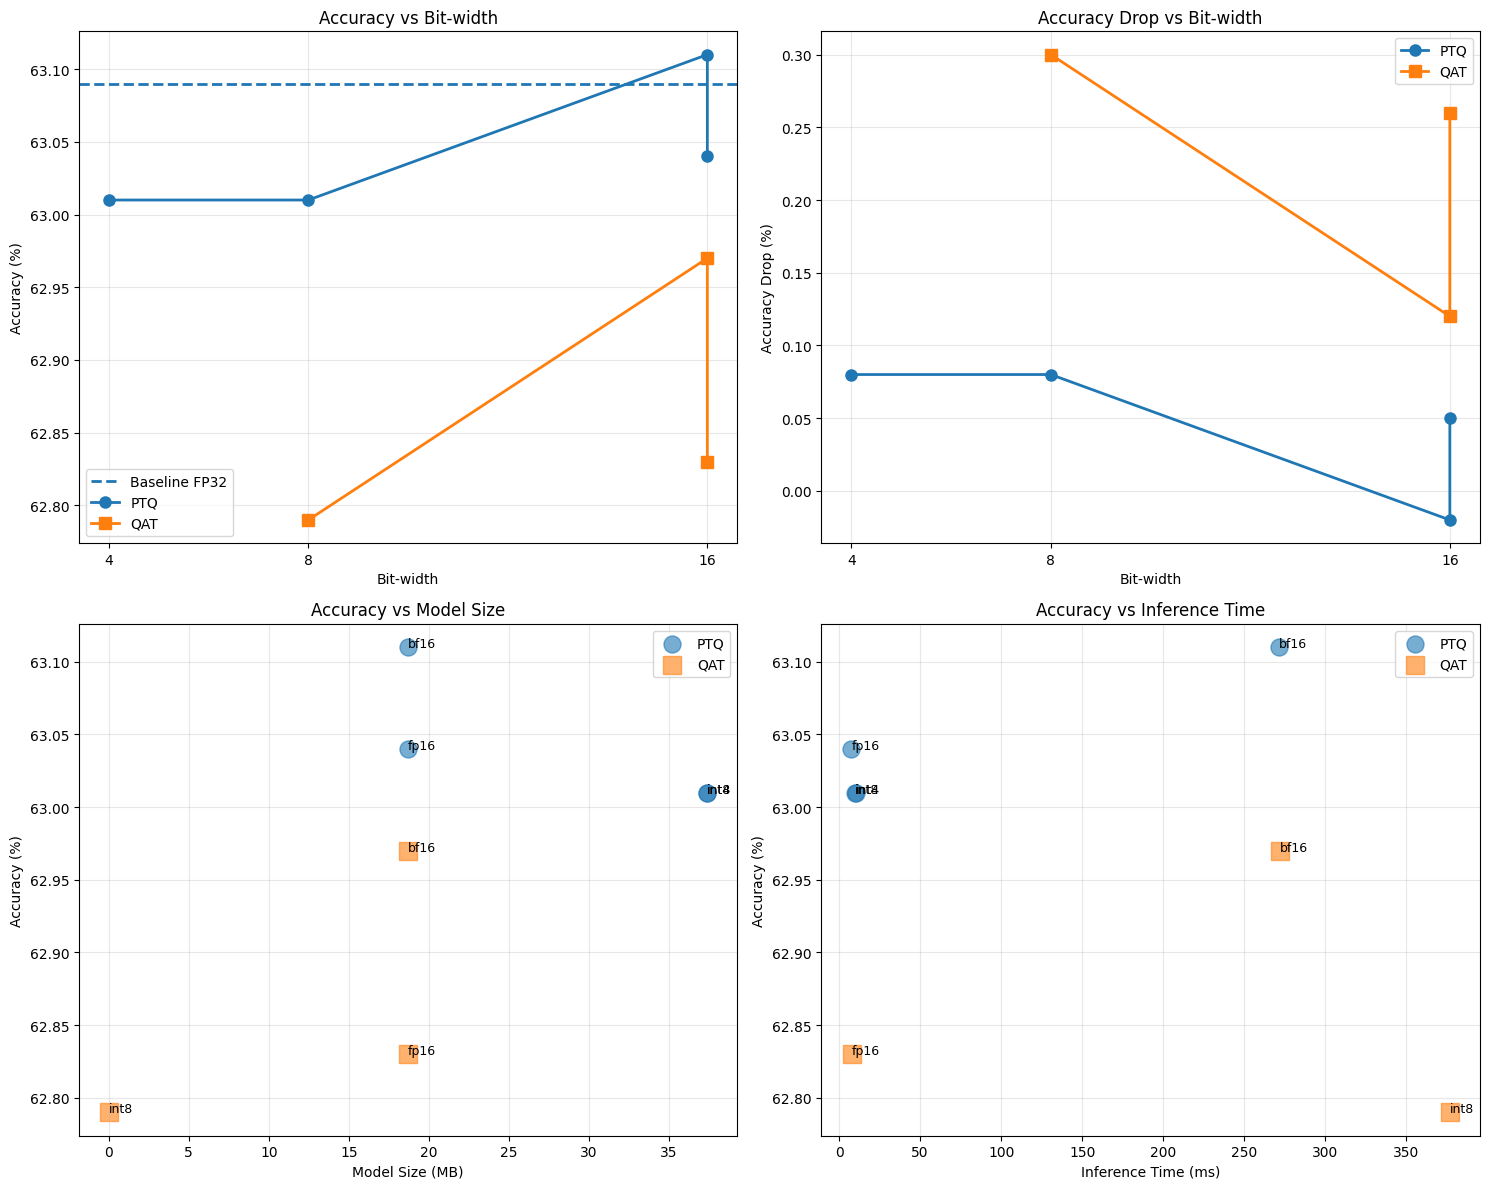


Scaling Law Observations:
------------------------------------------------------------
1. PTQ degrades most at lowest bit-width (e.g., int4: 63.01%)
2. QAT recovers performance, especially at int8 (≈ 62.79%).
3. Model size reduction: FP32 → int8 ≈ 4× compression.
4. Diminishing returns observed below 8-bit precision.


In [10]:
print("\n[3/6] Plotting scaling-law analysis...")
plot_scaling_laws(baseline_acc, ptq_results, qat_results)


[4/6] Running mixed-precision experiments...

TASK 3: MIXED-PRECISION QUANTIZATION


Configuration 1: Uniform int8 quantization
------------------------------------------------------------


Accuracy: 63.01%
Model Size: 37.41 MB
Inference Time: 12.29 ms

Configuration 2: Simple mixed-precision (first/last fp16, rest int8)
------------------------------------------------------------
Note: Full layer-wise precision control would use custom wrappers;
here we demonstrate analysis flow, not per-layer deployment.

Configuration 3: Adaptive mixed-precision (sensitivity-based)
------------------------------------------------------------

Layer Sensitivity Analysis (Top 5 by variance):
1. classifier.6 | Var: 36.253639 | MeanAbs: 4.573964 | MaxAbs: 49.346245
2. classifier.4 | Var: 2.662459 | MeanAbs: 1.128795 | MaxAbs: 18.910273
3. classifier.1 | Var: 1.375022 | MeanAbs: 0.931166 | MaxAbs: 8.370895
4. features.4 | Var: 1.137032 | MeanAbs: 0.897285 | MaxAbs: 12.779781
5. features.0 | Var: 0.578658 | MeanAbs: 0.477714 | MaxAbs: 12.497400


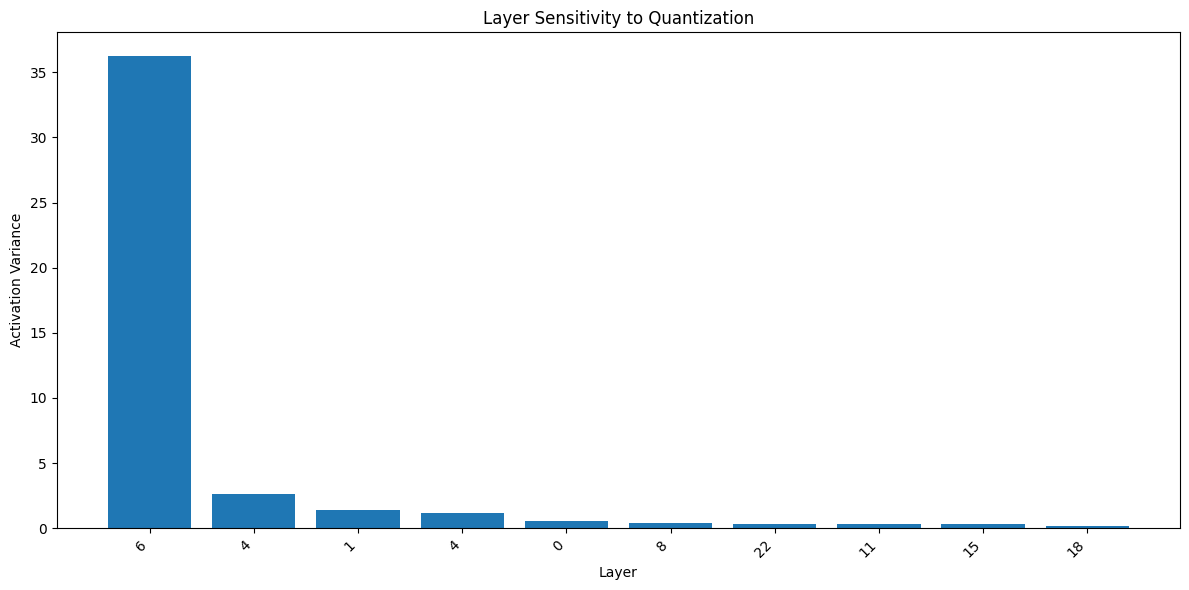

In [11]:
print("\n[4/6] Running mixed-precision experiments...")
mixed_precision_results = run_mixed_precision_experiments(baseline_model)


[5/6] Running outlier & clipping analysis...

TASK 4: COMPARING OUTLIER HANDLING STRATEGIES

Analyzing activation outliers in baseline model...



TASK 4: OUTLIER ANALYSIS - ACTIVATION DISTRIBUTIONS



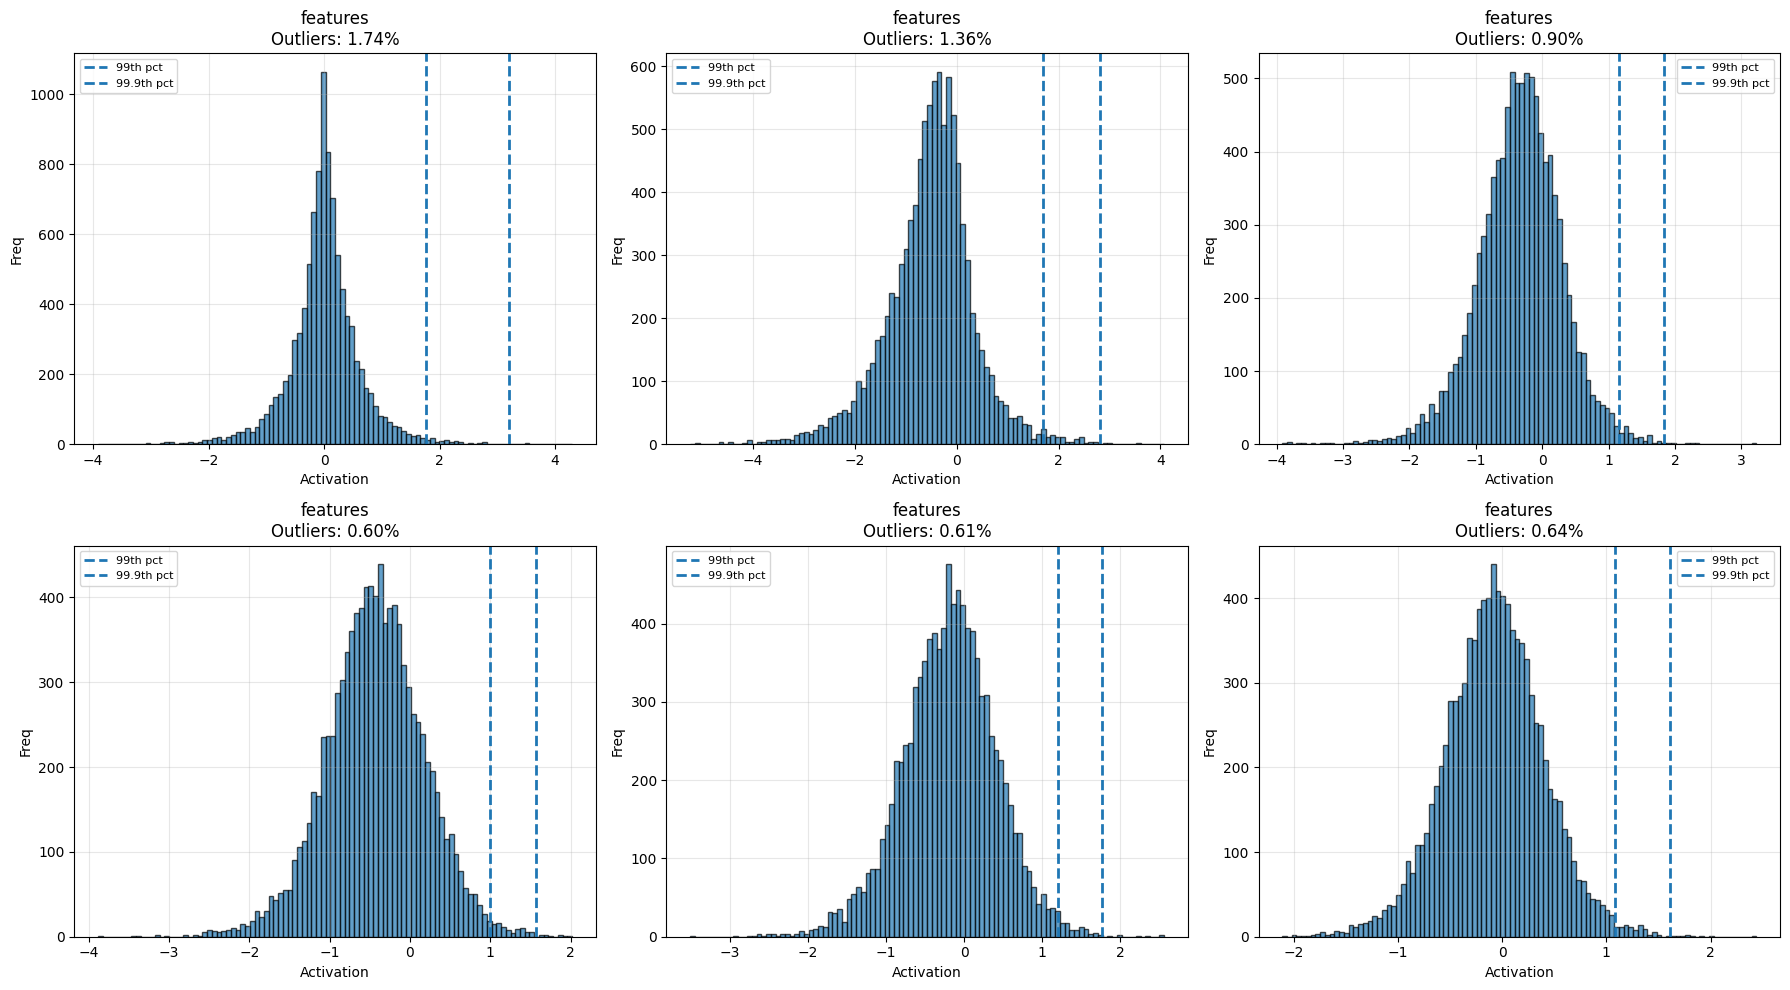

/tmp/ipython-input-161148574.py:265: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


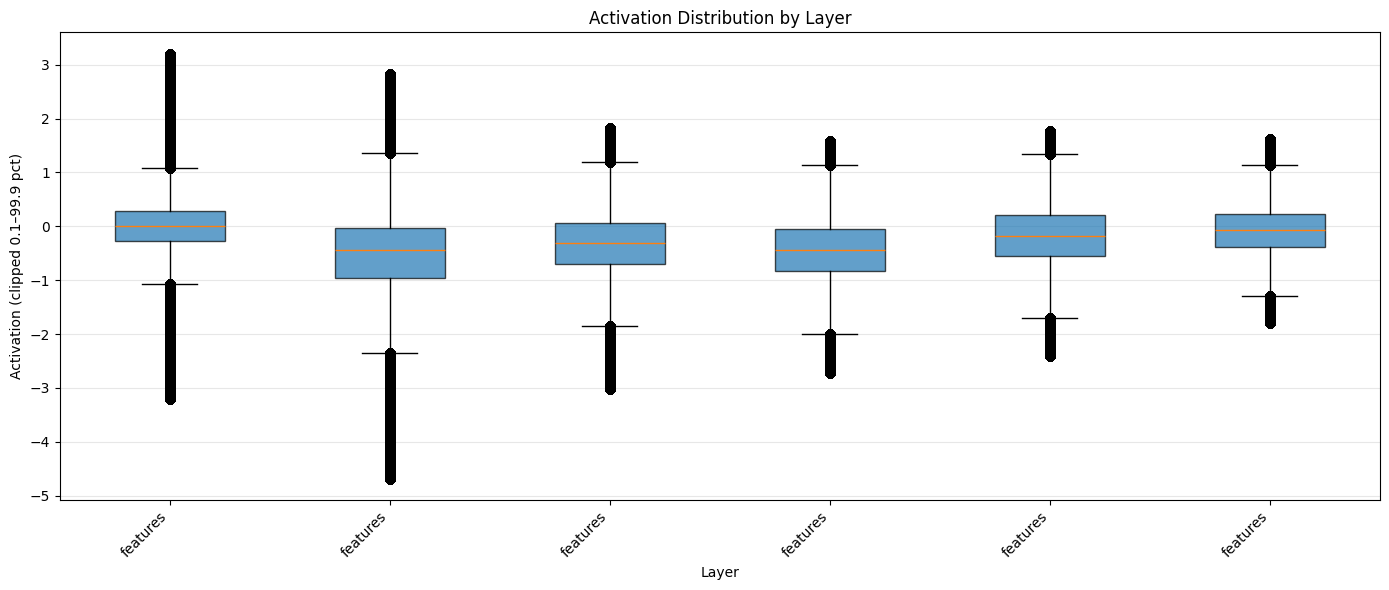


Outlier Summary Statistics:
--------------------------------------------------------------------------------
Layer                          Mean         Std          Max          Outliers %  
--------------------------------------------------------------------------------
features                       -0.0001      0.6187       10.2781      1.74        
features                       -0.5239      0.8812       12.6718      1.36        
features                       -0.3360      0.6264       8.0574       0.90        
features                       -0.4413      0.6128       6.3816       0.60        
features                       -0.1886      0.5976       5.0491       0.61        
features                       -0.0794      0.4828       4.7606       0.64        
features                       -0.3340      0.6313       4.4912       0.42        
features                       0.1242       0.4089       4.4453       1.16        
classifier                     0.3382       1.1979       10.53

INT8 - Accuracy: 63.01%, Size: 37.41 MB

CUDA: registered at /pytorch/build/aten/src/ATen/RegisterCUDA_0.cpp:16092 [kernel]
Meta: registered at /dev/null:488 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at /pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:375 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrVie

INT4 - Accuracy: 63.01%, Size: 37.41 MB

Strategy 2: Clipped Quantization (99.9 percentile) — calibration hooks



Clipping Thresholds (First 5 layers):
features: 5.4236 (reduces max by 47.2%)
features: 6.0115 (reduces max by 52.6%)
features: 3.0238 (reduces max by 62.5%)
features: 2.6274 (reduces max by 58.8%)
features: 2.2946 (reduces max by 54.6%)


Eval with activation clamping hooks attached: 62.85%


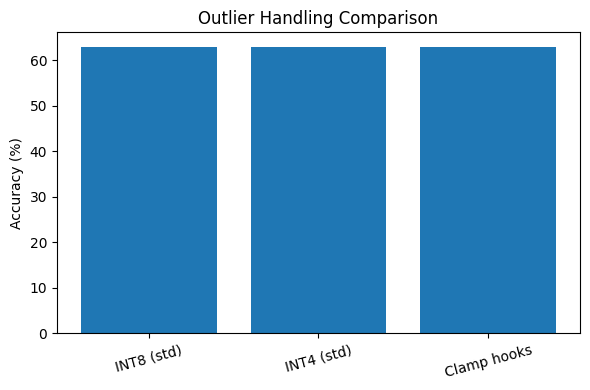

In [12]:
print("\n[5/6] Running outlier & clipping analysis...")
outlier_results = compare_outlier_handling_strategies(baseline_model)

In [13]:
print("\n[6/6] Creating results summary...")
create_results_summary(
    baseline_acc=baseline_acc,
    ptq_results=ptq_results,
    qat_results=qat_results,
    mixed_precision_results=mixed_precision_results,
    outlier_results=outlier_results,
)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated files (check your working directory):")
print("- vgg11_baseline.pth")
print("- scaling_law_analysis.png")
print("- layer_sensitivity.png")
print("- activation_distributions.png")
print("- activation_boxplots.png")
print("- outlier_handling_comparison.png")
print("- qat_training_curves.png")
print("- quantization_results_summary.csv")


[6/6] Creating results summary...

COMPREHENSIVE RESULTS SUMMARY

       Method  Bit-width  Accuracy (%)  Accuracy Drop (%) Model Size (MB) Compression Ratio
Baseline FP32         32         63.09               0.00             N/A                1x
     PTQ-fp16         16         63.04               0.05           18.71              2.0x
     PTQ-bf16         16         63.11              -0.02           18.71              2.0x
     PTQ-int8          8         63.01               0.08           37.41              4.0x
     PTQ-int4          4         63.01               0.08           37.41              8.0x
     QAT-fp16         16         62.83               0.26           18.71              2.0x
     QAT-bf16         16         62.97               0.12           18.71              2.0x
     QAT-int8          8         62.79               0.30            0.00              4.0x

Saved -> quantization_results_summary.csv

KEY FINDINGS:
-----------------------------------------------